# NSMC 데이터를 통한 영화 리뷰 평점 예측 및 분류모델

## 1. NSMC 불러와서 데이터 전처리 및 정제하기

* 감정분석을 위해, Naver Movie Corpus(https://github.com/e9t/nsmc/) 를 사용합니다.

In [2]:
from konlpy.tag import Mecab,Okt
import nltk
import re
from wordcloud import WordCloud

import json
import os
import re
from pprint import pprint

okt = Okt() # 큰 토막토막으로 pos데이터를 나눈다. 그래서 소셜데이터 분석할 때 유용함. twitter를 통해서 만든 형태소분석기이다.
mecab = Mecab('C:\mecab\mecab-ko-dic')

In [3]:
def read_documents(filename):
    # NSMC 불러오는 함수.
    with open(filename, encoding='utf-8') as f:
        documents = [line.split('\t') for line in f.read().splitlines()]
        documents = documents[1:
        ]
    return documents
    
train_docs = read_documents(r"C:\Users\Aytekin\Desktop\study\Fastcampus_textmining\data\nsmc\ratings_train.txt")
test_docs = read_documents(r"C:\Users\Aytekin\Desktop\study\Fastcampus_textmining\data\nsmc\ratings_test.txt")

In [4]:
# 데이터 개수
print(len(train_docs))
print(len(test_docs))

150000
50000


### 함수 정의.

In [5]:
def text_cleaning(doc):
    # 한국어를 제외한 글자를 제거하는 함수.
    doc = re.sub("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]", "", doc)
    return doc

def define_stopwords(path):
    
    SW = set()
    # 불용어를 추가하는 방법 1.
    # SW.add("있다")
    
    # 불용어를 추가하는 방법 2.
    # stopwords-ko.txt에 직접 추가
    
    with open(path, encoding='utf-8') as f:
        for word in f:
            SW.add(word)
            
    return SW

# tokenizing을 위한 함수
def text_tokenizing_morphs_mecab(doc):
    return [word for word in mecab.morphs(doc) if word not in SW and len(word) > 1]
def text_tokenizing_nouns_mecab(doc):
    return [word for word in mecab.nouns(doc) if word not in SW and len(word) > 1]
def text_tokenizing_nouns_okt(doc):
    return [word for word in okt.nouns(doc) if word not in SW and len(word) > 1]
def text_tokenizing_morphs_okt(doc):
    return [word for word in okt.morphs(doc) if word not in SW and len(word) > 1]

SW = define_stopwords("data/stopwords-ko.txt")

### 불러온 데이터를 품사 태그를 붙여서 토크나이징합니다.

In [6]:
print('original text :{} '.format(train_docs[0][1]))
print('(mecab_morphs) tokenized text :{} '.format(text_tokenizing_morphs_mecab(train_docs[0][1])))
print('(mecab_nouns) tokenized text :{} '.format(text_tokenizing_nouns_mecab(train_docs[0][1])))
print('(okt_morphs) tokenized text :{} '.format(text_tokenizing_morphs_okt(train_docs[0][1])))
print('(okt_nouns) tokenized text :{} '.format(text_tokenizing_nouns_okt(train_docs[0][1])))

original text :아 더빙.. 진짜 짜증나네요 목소리 
(mecab_morphs) tokenized text :['진짜', '짜증', '네요', '목소리'] 
(mecab_nouns) tokenized text :['짜증', '목소리'] 
(okt_morphs) tokenized text :['더빙', '..', '진짜', '짜증나네요', '목소리'] 
(okt_nouns) tokenized text :['더빙', '진짜', '목소리'] 


In [7]:
# 형태소 분리 기준 - mecab.morphs

if os.path.exists("train_docs_morphs_mecab.json"):
    # 불러오기
    print('불러옵니다.')
    with open("train_docs_morphs_mecab.json",encoding='utf-8') as f:
        train_data_mecab_morphs = json.load(f)
else:
    # 형태소분석 하여 json으로 저장.
    train_data_mecab_morphs = [(text_tokenizing_morphs_mecab(line[1]), line[2]) for line in train_docs if text_tokenizing_morphs_mecab(line[1])]
    
    with open("train_docs_morphs_mecab.json",'w', encoding='utf-8') as f:
        json.dump(train_data_mecab_morphs, f, ensure_ascii=False, indent='\t')
        
if os.path.exists("test_docs_morphs_mecab.json"):
    # 불러오기
    print('불러옵니다.')
    with open("test_docs_morphs_mecab.json",encoding='utf-8') as f:
        test_data_mecab_morphs = json.load(f)
else:
    # 형태소분석 하여 json으로 저장.
    test_data_mecab_morphs = [(text_tokenizing_morphs_mecab(line[1]), line[2]) for line in test_docs if text_tokenizing_morphs_mecab(line[1])]
    
    with open("test_docs_morphs_mecab.json",'w', encoding='utf-8') as f:
        json.dump(test_data_mecab_morphs, f, ensure_ascii=False, indent='\t')

print('\n형태소 분리 기준 : mecab - morphs')
print()
print(train_data_mecab_morphs[0][0])
print('train data 수 :',len(train_data_mecab_morphs))
print('test data 수 :',len(test_data_mecab_morphs))

불러옵니다.
불러옵니다.

형태소 분리 기준 : mecab - morphs

['진짜', '짜증', '네요', '목소리']
train data 수 : 148051
test data 수 : 49359


In [8]:
# 텍스트가 20만개이기 때문에, 정제하는데 시간이 걸린다.
# 한 번 만들고 나서는 코드를 다시 실행시켰을 때, 또 정제할 필요없이 불러오게끔 코드를 짜보자.

# 형태소 분리 기준 - mecab.nouns
if os.path.exists("train_docs_nouns_mecab.json"):
    # 불러오기
    print('불러옵니다.')
    with open("train_docs_nouns_mecab.json",encoding='utf-8') as f:
        train_data_mecab_nouns = json.load(f)
else:
    # 형태소분석 하여 json으로 저장.
    train_data_mecab_nouns = [(text_tokenizing_nouns_mecab(line[1]), line[2]) for line in train_docs if text_tokenizing_nouns_mecab(line[1])]
    
    with open("train_docs_nouns_mecab.json",'w', encoding='utf-8') as f:
        json.dump(train_data_mecab_nouns, f, ensure_ascii=False, indent='\t')
        
if os.path.exists("test_docs_nouns_mecab.json"):
    # 불러오기
    print('불러옵니다.')
    with open("test_docs_nouns_mecab.json",encoding='utf-8') as f:
        test_data_mecab_nouns = json.load(f)
else:
    # 형태소분석 하여 json으로 저장.
    test_data_mecab_nouns = [(text_tokenizing_nouns_mecab(line[1]), line[2]) for line in test_docs if text_tokenizing_nouns_mecab(line[1])]
    
    with open("test_docs_nouns_mecab.json",'w', encoding='utf-8') as f:
        json.dump(test_data_mecab_nouns, f, ensure_ascii=False, indent='\t')


print('\n형태소 분리 기준 : mecab - nouns')
print()
print(train_data_mecab_nouns[0][0])
print('train data 수 :',len(train_data_mecab_nouns))
print('test data 수 :',len(test_data_mecab_nouns))

불러옵니다.
불러옵니다.

형태소 분리 기준 : mecab - nouns

['짜증', '목소리']
train data 수 : 134885
test data 수 : 45034


In [9]:
# 형태소 분리 기준 - okt.morphs
if os.path.exists("train_docs_morphs_okt.json"):
    # 불러오기
    print('불러옵니다.')
    with open("train_docs_morphs_okt.json",encoding='utf-8') as f:
        train_data_okt_morphs = json.load(f)
else:
    # 형태소분석 하여 json으로 저장.
    train_data_okt_morphs = [(text_tokenizing_morphs_okt(line[1]), line[2]) for line in train_docs if text_tokenizing_morphs_okt(line[1])]
    
    with open("train_docs_morphs_okt.json",'w', encoding='utf-8') as f:
        json.dump(train_data_okt_morphs, f, ensure_ascii=False, indent='\t')
        
if os.path.exists("test_docs_morphs_okt.json"):
    # 불러오기
    print('불러옵니다.')
    with open("test_docs_morphs_okt.json",encoding='utf-8') as f:
        test_data_okt_morphs = json.load(f)
else:
    # 형태소분석 하여 json으로 저장.
    test_data_okt_morphs = [(text_tokenizing_morphs_okt(line[1]), line[2]) for line in test_docs if text_tokenizing_morphs_okt(line[1])]
    
    with open("test_docs_morphs_okt.json",'w', encoding='utf-8') as f:
        json.dump(test_data_okt_morphs, f, ensure_ascii=False, indent='\t')


print('\n형태소 분리 기준 : okt - morphs')
print()
print(train_data_okt_morphs[0][0])
print('train data 수 :',len(train_data_okt_morphs))
print('test data 수 :',len(test_data_okt_morphs))

불러옵니다.
불러옵니다.

형태소 분리 기준 : okt - morphs

['더빙', '..', '진짜', '짜증나네요', '목소리']
train data 수 : 148969
test data 수 : 49632


In [10]:
# 형태소 분리 기준 - okt.nouns
if os.path.exists("train_docs_nouns_okt.json"):
    # 불러오기
    print('불러옵니다.')
    with open("train_docs_nouns_okt.json",encoding='utf-8') as f:
        train_data_okt_nouns = json.load(f)
else:
    # 형태소분석 하여 json으로 저장.
    train_data_okt_nouns = [(text_tokenizing_nouns_okt(line[1]), line[2]) for line in train_docs if text_tokenizing_nouns_okt(line[1])]
    
    with open("train_docs_nouns_okt.json",'w', encoding='utf-8') as f:
        json.dump(train_data_okt_nouns, f, ensure_ascii=False, indent='\t')
        
if os.path.exists("test_docs_nouns_okt.json"):
    # 불러오기
    print('불러옵니다.')
    with open("test_docs_nouns_okt.json",encoding='utf-8') as f:
        test_data_okt_nouns = json.load(f)
else:
    # 형태소분석 하여 json으로 저장.
    test_data_okt_nouns = [(text_tokenizing_nouns_okt(line[1]), line[2]) for line in test_docs if text_tokenizing_nouns_okt(line[1])]
    
    with open("test_docs_nouns_okt.json",'w', encoding='utf-8') as f:
        json.dump(test_data_okt_nouns, f, ensure_ascii=False, indent='\t')


print('\n형태소 분리 기준 : okt - nouns')
print()
print(train_data_okt_nouns[0][0])
print('train data 수 :',len(train_data_okt_nouns))
print('test data 수 :',len(test_data_okt_nouns))

불러옵니다.
불러옵니다.

형태소 분리 기준 : okt - nouns

['더빙', '진짜', '목소리']
train data 수 : 139578
test data 수 : 46667


## 2. Visualization

### NLTK를 이용한 histogram 분석.

* 데이터 분석을 하기 위해 기본적인 정보들을 확인합니다.

* nltk 라이브러리를 이용하여 histogram을 봅니다.

In [11]:
# 리스트 컴프리핸션을 사용
total_tokens_mecab_nouns = [token for doc in train_data_mecab_nouns for token in doc[0]]
total_tokens_mecab_morphs = [token for doc in train_data_mecab_morphs for token in doc[0]]
total_tokens_okt_nouns = [token for doc in train_data_okt_nouns for token in doc[0]]
total_tokens_okt_morphs = [token for doc in train_data_okt_nouns for token in doc[0]]

In [12]:
text_mecab_morphs = nltk.Text(total_tokens_mecab_morphs, name='mecab_morphs')
text_mecab_nouns = nltk.Text(total_tokens_mecab_nouns, name='mecab_nouns')
text_okt_morphs = nltk.Text(total_tokens_okt_morphs, name='okt_morphs')
text_okt_nouns = nltk.Text(total_tokens_okt_nouns, name='okt_nouns')
print(len(set(text_mecab_nouns.tokens)))
pprint(text_mecab_nouns.vocab().most_common(10))

# 소셜데이터의 경우엔 먼저 클리닝을 실행하지 말고 일단 토크나이징 된 결과를 보고 나서 의미 분석을 해 본 후에 클리닝 할지 말지 결정하는 것이 좋다.

30917
[('영화', 57614),
 ('연기', 6835),
 ('최고', 6595),
 ('평점', 6297),
 ('스토리', 5422),
 ('드라마', 5192),
 ('생각', 5168),
 ('사람', 5035),
 ('감동', 4860),
 ('배우', 4450)]


### Histogram 그리기.

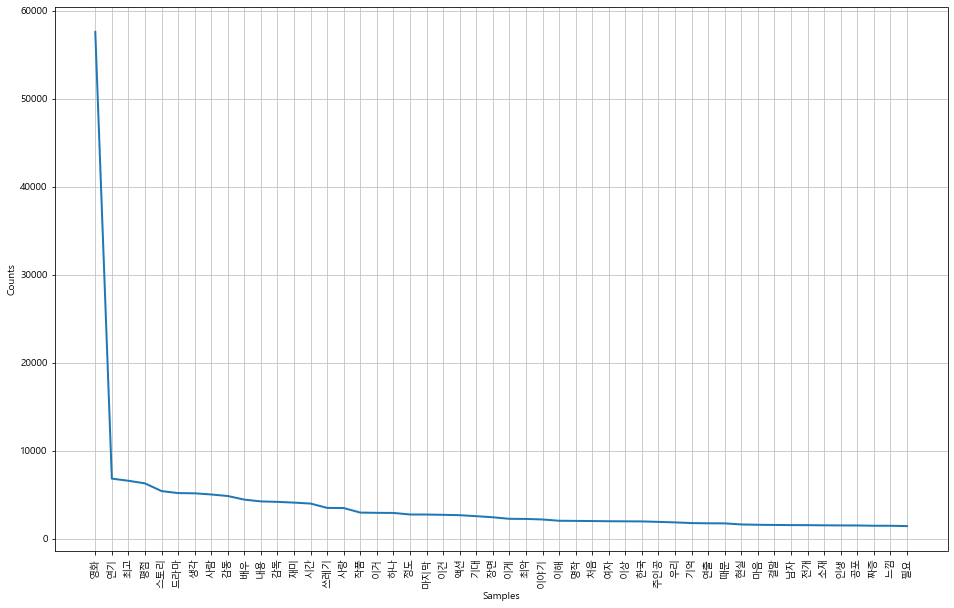

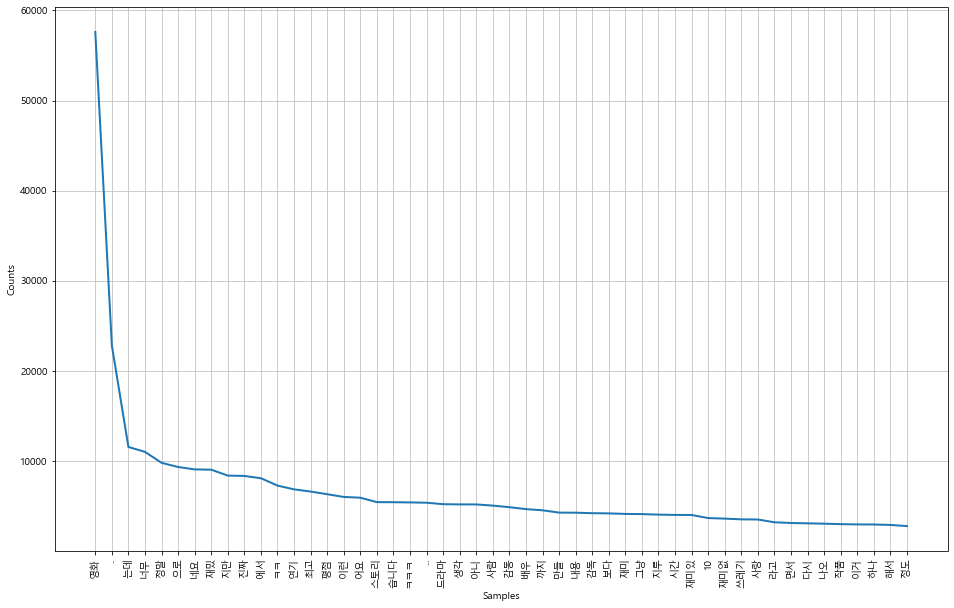

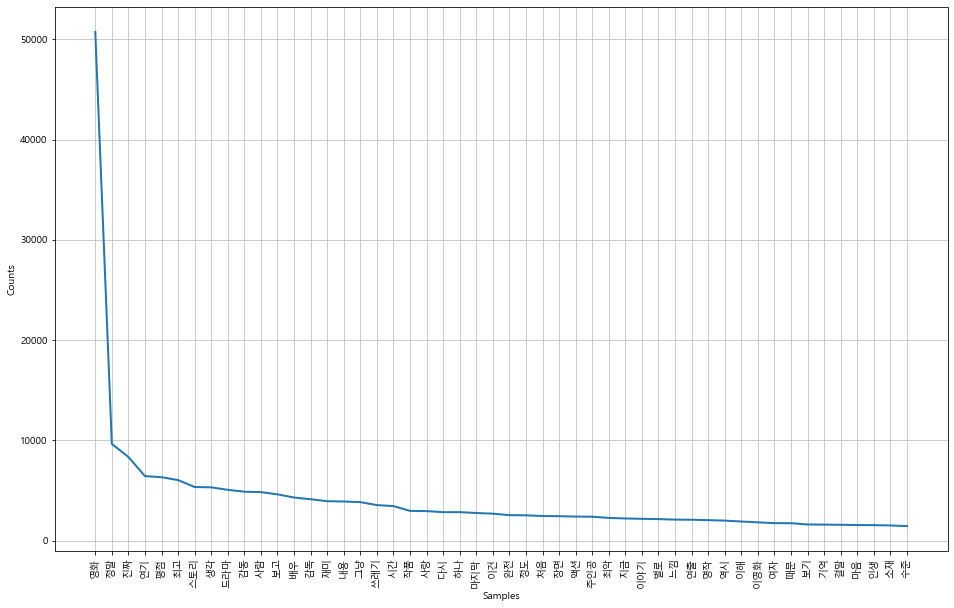

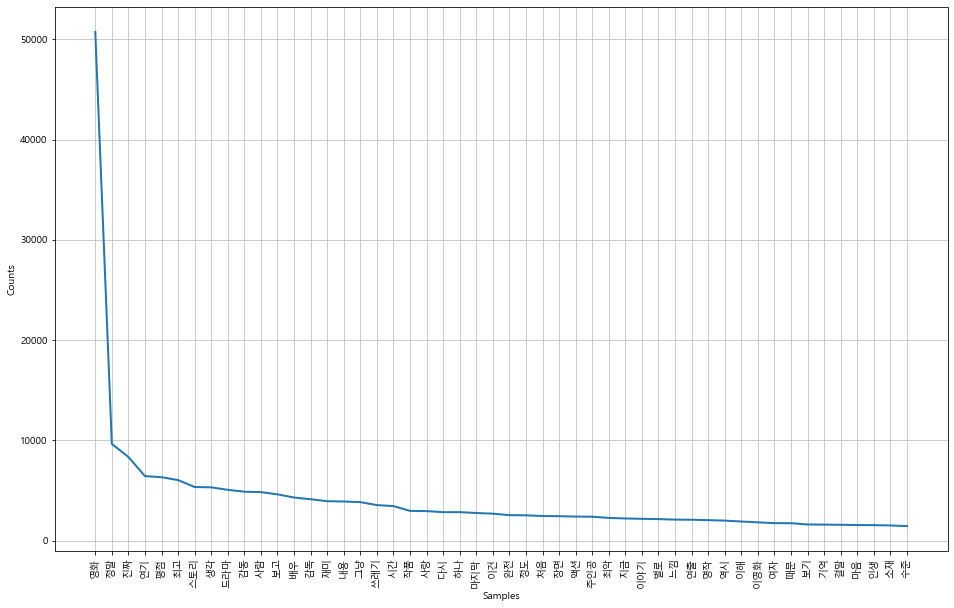

In [13]:
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
%matplotlib inline

path = "c:/Windows/Fonts/malgun.ttf"
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

plt.figure(figsize=(16, 10))
text_mecab_nouns.plot(50)

plt.figure(figsize=(16, 10))
text_mecab_morphs.plot(50)

plt.figure(figsize=(16, 10))
text_okt_morphs.plot(50)

plt.figure(figsize=(16, 10))
text_okt_nouns.plot(50)

### WordCloud 그리기.

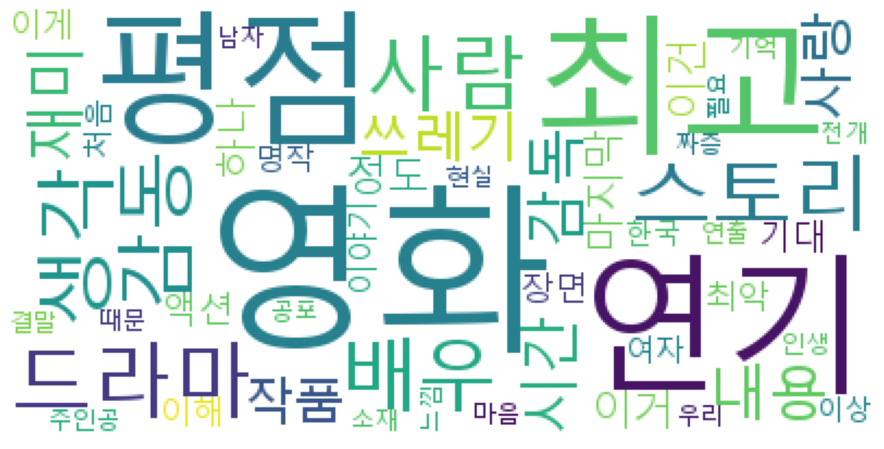

In [14]:
# 워드클라우드 명사로 넣었을때
data = text_mecab_nouns.vocab().most_common(50)

# for windows : font_path='c:/Windows/Fonts/malgun.ttf'
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 워드클라우드 할 때는 보통 명사를 많이 쓴다.

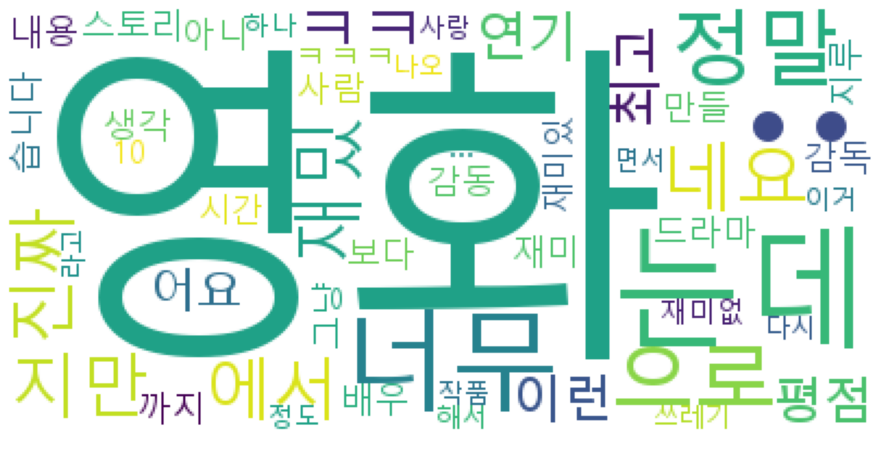

In [15]:
# 워드클라우드 명사로 넣었을때
data = text_mecab_morphs.vocab().most_common(50)

# for windows : font_path='c:/Windows/Fonts/malgun.ttf'
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 워드클라우드 할 때는 보통 명사를 많이 쓴다.

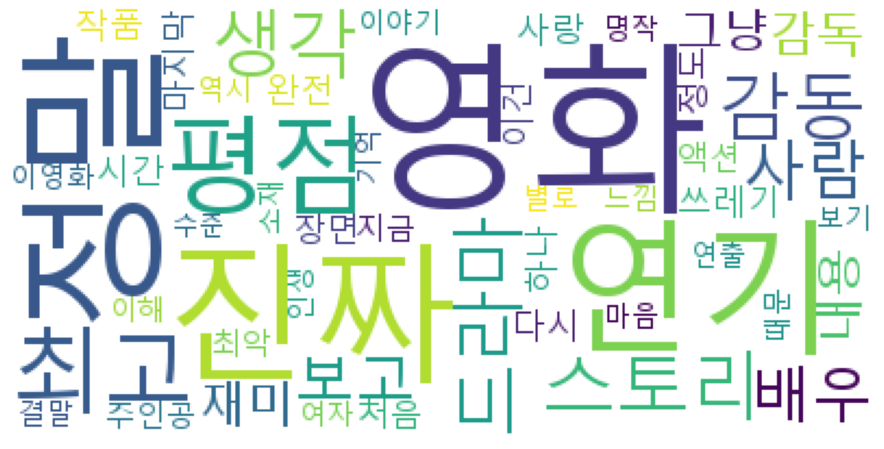

In [16]:
# 워드클라우드 명사로 넣었을때
data = text_okt_nouns.vocab().most_common(50)

# for windows : font_path='c:/Windows/Fonts/malgun.ttf'
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 워드클라우드 할 때는 보통 명사를 많이 쓴다.

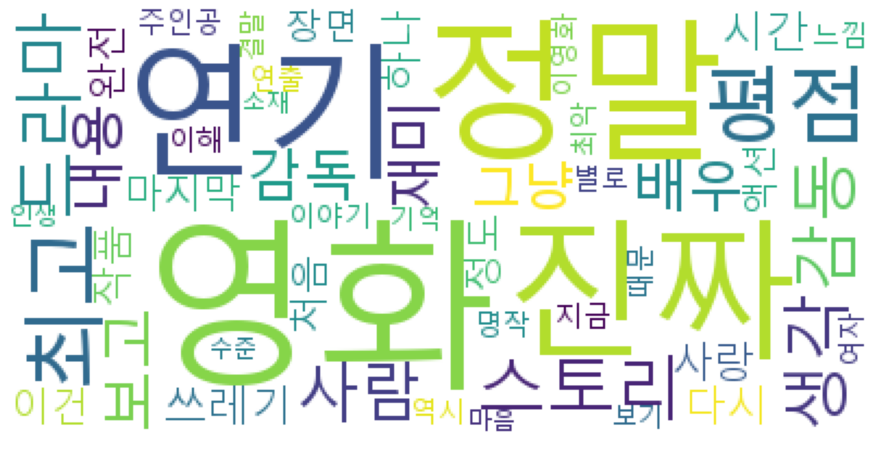

In [17]:
# 워드클라우드 명사로 넣었을때
data = text_okt_morphs.vocab().most_common(50)

# for windows : font_path='c:/Windows/Fonts/malgun.ttf'
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(dict(data))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# 워드클라우드 할 때는 보통 명사를 많이 쓴다.

# 3. scikit-learn으로 NSMC 감정분석 하기

In [18]:
# 여러 리스트들을 하나로 묶어 주는 함수입니다.
def list_to_str(List): 
    return " ".join(List)
print(train_data_mecab_nouns[0])
train_x = [list_to_str(doc) for doc, _ in train_data_mecab_nouns]
train_x[0]

[['짜증', '목소리'], '0']


'짜증 목소리'

## Linear Classifier와 Support Vector Machine으로 nsmc 분류하기

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pickle
from tqdm import tqdm 

# 학습 모델 파이프라인 만들기

# 1. perceptron linear classifier
learner = Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                         alpha=1e-4, random_state=42,
                         max_iter=1000))
])

# 2. SVM with linear kernel
learner2 = Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('clf', SVC(kernel='linear',random_state=42,max_iter=1000))
])

# 3. SVM with polynomial kernel
learner3 = Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('clf', SVC(kernel='poly', degree=8,random_state=42,max_iter=1000))
])

# 4. SVM with radius Basis Function kernel
learner4 = Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('clf', SVC(kernel='rbf',random_state=42,max_iter=1000))
])

# 5. SVM with sigmoid kernel
learner5 = Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('clf', SVC(kernel='sigmoid',random_state=42,max_iter=1000))
])

# 6. Naive Bayes Classifier (multinomial Ver.)
# 나이브 베이즈는 차원간 독립성을 보장만 한다면 성능이 좋다. 근데 토크나이징 한다는 것 자체가 각각의 차원들을 독립적으로 만든다는 것.
learner6 = Pipeline([
    ('vect', CountVectorizer(min_df=5)),
    ('mb', MultinomialNB())
])

# tokenized text list
tokenized_texts = [
    (train_data_mecab_morphs, test_data_mecab_morphs, 'mecab_morphs'), 
    (train_data_mecab_nouns, test_data_mecab_nouns, 'mecab_nouns'), 
    (train_data_okt_morphs, test_data_okt_morphs, 'okt_morphs'), 
    (train_data_okt_nouns, test_data_okt_nouns, 'okt_nouns'), 
    ]

# 학습기 리스트
classifiers = [learner, learner2, learner3, learner4, learner5, learner6]

for tokenized_text in tokenized_texts:
    for classifier in tqdm(classifiers):
        print('==='*30)
        print('tokenized_text : {}'.format(tokenized_text[2]))
        classifier_name = str(list(classifier.named_steps.keys())[1])
        print('classifier : {}'.format(classifier.named_steps[classifier_name]))
        print('vectorizer : {}'.format(classifier.named_steps['vect']))
        train_x = [list_to_str(doc) for doc, _ in tokenized_text[0]]
        test_x = [list_to_str(doc) for doc, _ in tokenized_text[1]]
        train_y = [label for _, label in tokenized_text[0]]
        test_y = [label for _, label in tokenized_text[1]]
        

        # 학습
        classifier.fit(train_x, train_y)

        train_predict = classifier.predict(train_x)
        train_accuracy = np.mean(train_predict == train_y)

        test_predict = classifier.predict(test_x)
        test_accuracy = np.mean(test_predict == test_y)

        print("For %d train data" % len(train_x))
        print("For %d test data" % len(test_x))

        print("Training Accuracy : %.2f" % train_accuracy)
        print("Test Accuracy : %.2f" % test_accuracy)
        print()

        with open('models/{}-{}.pk'.format(tokenized_text[2],classifier.named_steps[classifier_name]),'wb') as f:
            pickle.dump(classifier, f)

  0%|          | 0/6 [00:00<?, ?it/s]

tokenized_text : mecab_morphs
classifier : SGDClassifier(loss='perceptron', random_state=42)
vectorizer : CountVectorizer(min_df=5)


 17%|█▋        | 1/6 [00:02<00:13,  2.67s/it]

For 148051 train data
For 49359 test data
Training Accuracy : 0.81
Test Accuracy : 0.77

tokenized_text : mecab_morphs
classifier : SVC(kernel='linear', max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 33%|███▎      | 2/6 [00:40<00:52, 13.12s/it]

For 148051 train data
For 49359 test data
Training Accuracy : 0.53
Test Accuracy : 0.53

tokenized_text : mecab_morphs
classifier : SVC(degree=8, kernel='poly', max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 50%|█████     | 3/6 [01:10<00:54, 18.21s/it]

For 148051 train data
For 49359 test data
Training Accuracy : 0.50
Test Accuracy : 0.50

tokenized_text : mecab_morphs
classifier : SVC(max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 67%|██████▋   | 4/6 [01:24<00:33, 16.92s/it]

For 148051 train data
For 49359 test data
Training Accuracy : 0.51
Test Accuracy : 0.51

tokenized_text : mecab_morphs
classifier : SVC(kernel='sigmoid', max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 83%|████████▎ | 5/6 [02:06<00:24, 24.43s/it]

For 148051 train data
For 49359 test data
Training Accuracy : 0.50
Test Accuracy : 0.50

tokenized_text : mecab_morphs
classifier : MultinomialNB()
vectorizer : CountVectorizer(min_df=5)


  0%|          | 0/6 [00:00<?, ?it/s]

For 148051 train data
For 49359 test data
Training Accuracy : 0.84
Test Accuracy : 0.82

tokenized_text : mecab_nouns
classifier : SGDClassifier(loss='perceptron', random_state=42)
vectorizer : CountVectorizer(min_df=5)


 17%|█▋        | 1/6 [00:01<00:08,  1.65s/it]

For 134885 train data
For 45034 test data
Training Accuracy : 0.71
Test Accuracy : 0.68

tokenized_text : mecab_nouns
classifier : SVC(kernel='linear', max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 33%|███▎      | 2/6 [00:22<00:29,  7.50s/it]

For 134885 train data
For 45034 test data
Training Accuracy : 0.52
Test Accuracy : 0.52

tokenized_text : mecab_nouns
classifier : SVC(degree=8, kernel='poly', max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 50%|█████     | 3/6 [00:34<00:25,  8.65s/it]

For 134885 train data
For 45034 test data
Training Accuracy : 0.50
Test Accuracy : 0.50

tokenized_text : mecab_nouns
classifier : SVC(max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 67%|██████▋   | 4/6 [00:44<00:18,  9.06s/it]

For 134885 train data
For 45034 test data
Training Accuracy : 0.51
Test Accuracy : 0.51

tokenized_text : mecab_nouns
classifier : SVC(kernel='sigmoid', max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 83%|████████▎ | 5/6 [01:12<00:14, 14.81s/it]

For 134885 train data
For 45034 test data
Training Accuracy : 0.51
Test Accuracy : 0.51

tokenized_text : mecab_nouns
classifier : MultinomialNB()
vectorizer : CountVectorizer(min_df=5)


  0%|          | 0/6 [00:00<?, ?it/s]

For 134885 train data
For 45034 test data
Training Accuracy : 0.77
Test Accuracy : 0.75

tokenized_text : okt_morphs
classifier : SGDClassifier(loss='perceptron', random_state=42)
vectorizer : CountVectorizer(min_df=5)


 17%|█▋        | 1/6 [00:03<00:15,  3.02s/it]

For 148969 train data
For 49632 test data
Training Accuracy : 0.84
Test Accuracy : 0.79

tokenized_text : okt_morphs
classifier : SVC(kernel='linear', max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 33%|███▎      | 2/6 [00:42<00:56, 14.03s/it]

For 148969 train data
For 49632 test data
Training Accuracy : 0.55
Test Accuracy : 0.55

tokenized_text : okt_morphs
classifier : SVC(degree=8, kernel='poly', max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 50%|█████     | 3/6 [01:08<00:53, 17.70s/it]

For 148969 train data
For 49632 test data
Training Accuracy : 0.50
Test Accuracy : 0.50

tokenized_text : okt_morphs
classifier : SVC(max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 67%|██████▋   | 4/6 [01:22<00:32, 16.36s/it]

For 148969 train data
For 49632 test data
Training Accuracy : 0.50
Test Accuracy : 0.50

tokenized_text : okt_morphs
classifier : SVC(kernel='sigmoid', max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 83%|████████▎ | 5/6 [02:16<00:27, 27.78s/it]

For 148969 train data
For 49632 test data
Training Accuracy : 0.51
Test Accuracy : 0.50

tokenized_text : okt_morphs
classifier : MultinomialNB()
vectorizer : CountVectorizer(min_df=5)


  0%|          | 0/6 [00:00<?, ?it/s]

For 148969 train data
For 49632 test data
Training Accuracy : 0.86
Test Accuracy : 0.84

tokenized_text : okt_nouns
classifier : SGDClassifier(loss='perceptron', random_state=42)
vectorizer : CountVectorizer(min_df=5)


 17%|█▋        | 1/6 [00:01<00:09,  1.83s/it]

For 139578 train data
For 46667 test data
Training Accuracy : 0.72
Test Accuracy : 0.69

tokenized_text : okt_nouns
classifier : SVC(kernel='linear', max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 33%|███▎      | 2/6 [00:25<00:33,  8.40s/it]

For 139578 train data
For 46667 test data
Training Accuracy : 0.53
Test Accuracy : 0.53

tokenized_text : okt_nouns
classifier : SVC(degree=8, kernel='poly', max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 50%|█████     | 3/6 [00:39<00:30, 10.16s/it]

For 139578 train data
For 46667 test data
Training Accuracy : 0.50
Test Accuracy : 0.50

tokenized_text : okt_nouns
classifier : SVC(max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 67%|██████▋   | 4/6 [00:49<00:20, 10.11s/it]

For 139578 train data
For 46667 test data
Training Accuracy : 0.51
Test Accuracy : 0.51

tokenized_text : okt_nouns
classifier : SVC(kernel='sigmoid', max_iter=1000, random_state=42)
vectorizer : CountVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 83%|████████▎ | 5/6 [01:17<00:15, 15.34s/it]

For 139578 train data
For 46667 test data
Training Accuracy : 0.49
Test Accuracy : 0.50

tokenized_text : okt_nouns
classifier : MultinomialNB()
vectorizer : CountVectorizer(min_df=5)


100%|██████████| 6/6 [01:19<00:00, 13.18s/it]

For 139578 train data
For 46667 test data
Training Accuracy : 0.78
Test Accuracy : 0.76



In [42]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import pickle
from tqdm import tqdm 

# 학습 모델 파이프라인 만들기

# 1. perceptron linear classifier
learner = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5)),
    ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                         alpha=1e-4, random_state=42,
                         max_iter=1000))
])

# 2. SVM with linear kernel
learner2 = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5)),
    ('clf', SVC(kernel='linear',random_state=42,max_iter=1000))
])

# 3. SVM with polynomial kernel
learner3 = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5)),
    ('clf', SVC(kernel='poly', degree=8,random_state=42,max_iter=1000))
])

# 4. SVM with radius Basis Function kernel
learner4 = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5)),
    ('clf', SVC(kernel='rbf',random_state=42,max_iter=1000))
])

# 5. SVM with sigmoid kernel
learner5 = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5)),
    ('clf', SVC(kernel='sigmoid',random_state=42,max_iter=1000))
])

# 6. Naive Bayes Classifier (multinomial Ver.)
# 나이브 베이즈는 차원간 독립성을 보장만 한다면 성능이 좋다. 근데 토크나이징 한다는 것 자체가 각각의 차원들을 독립적으로 만든다는 것.
learner6 = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5)),
    ('mb', MultinomialNB())
])

# tokenized text list
tokenized_texts = [
    (train_data_mecab_morphs, test_data_mecab_morphs, 'mecab_morphs'), 
    (train_data_mecab_nouns, test_data_mecab_nouns, 'mecab_nouns'), 
    (train_data_okt_morphs, test_data_okt_morphs, 'okt_morphs'), 
    (train_data_okt_nouns, test_data_okt_nouns, 'okt_nouns'), 
    ]

# 학습기 리스트
classifiers = [learner, learner2, learner3, learner4, learner5, learner6]

for tokenized_text in tokenized_texts:
    for classifier in tqdm(classifiers):
        print('==='*30)
        print('tokenized_text : {}'.format(tokenized_text[2]))
        classifier_name = str(list(classifier.named_steps.keys())[1])
        print('classifier : {}'.format(classifier.named_steps[classifier_name]))
        print('vectorizer : {}'.format(classifier.named_steps['tfidf']))
        train_x = [list_to_str(doc) for doc, _ in tokenized_text[0]]
        test_x = [list_to_str(doc) for doc, _ in tokenized_text[1]]
        train_y = [label for _, label in tokenized_text[0]]
        test_y = [label for _, label in tokenized_text[1]]
        

        # 학습
        classifier.fit(train_x, train_y)

        train_predict = classifier.predict(train_x)
        train_accuracy = np.mean(train_predict == train_y)

        test_predict = classifier.predict(test_x)
        test_accuracy = np.mean(test_predict == test_y)

        print("For %d train data" % len(train_x))
        print("For %d test data" % len(test_x))

        print("Training Accuracy : %.2f" % train_accuracy)
        print("Test Accuracy : %.2f" % test_accuracy)
        print()

        with open('models_with_Tfidf/{}-{}.pk'.format(tokenized_text[2],classifier.named_steps[classifier_name]),'wb') as f:
            pickle.dump(classifier, f)

  0%|          | 0/6 [00:00<?, ?it/s]

tokenized_text : mecab_morphs
classifier : SGDClassifier(loss='perceptron', random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


 17%|█▋        | 1/6 [00:02<00:13,  2.62s/it]

For 148051 train data
For 49359 test data
Training Accuracy : 0.80
Test Accuracy : 0.76

tokenized_text : mecab_morphs
classifier : SVC(kernel='linear', max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 33%|███▎      | 2/6 [00:23<00:32,  8.17s/it]

For 148051 train data
For 49359 test data
Training Accuracy : 0.54
Test Accuracy : 0.55

tokenized_text : mecab_morphs
classifier : SVC(degree=8, kernel='poly', max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 50%|█████     | 3/6 [00:43<00:34, 11.54s/it]

For 148051 train data
For 49359 test data
Training Accuracy : 0.51
Test Accuracy : 0.51

tokenized_text : mecab_morphs
classifier : SVC(max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 67%|██████▋   | 4/6 [00:57<00:24, 12.30s/it]

For 148051 train data
For 49359 test data
Training Accuracy : 0.61
Test Accuracy : 0.60

tokenized_text : mecab_morphs
classifier : SVC(kernel='sigmoid', max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 83%|████████▎ | 5/6 [01:21<00:15, 15.77s/it]

For 148051 train data
For 49359 test data
Training Accuracy : 0.53
Test Accuracy : 0.53

tokenized_text : mecab_morphs
classifier : MultinomialNB()
vectorizer : TfidfVectorizer(min_df=5)


  0%|          | 0/6 [00:00<?, ?it/s]

For 148051 train data
For 49359 test data
Training Accuracy : 0.84
Test Accuracy : 0.82

tokenized_text : mecab_nouns
classifier : SGDClassifier(loss='perceptron', random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


 17%|█▋        | 1/6 [00:01<00:08,  1.61s/it]

For 134885 train data
For 45034 test data
Training Accuracy : 0.71
Test Accuracy : 0.68

tokenized_text : mecab_nouns
classifier : SVC(kernel='linear', max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 33%|███▎      | 2/6 [00:12<00:17,  4.37s/it]

For 134885 train data
For 45034 test data
Training Accuracy : 0.51
Test Accuracy : 0.51

tokenized_text : mecab_nouns
classifier : SVC(degree=8, kernel='poly', max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 50%|█████     | 3/6 [00:26<00:22,  7.33s/it]

For 134885 train data
For 45034 test data
Training Accuracy : 0.50
Test Accuracy : 0.50

tokenized_text : mecab_nouns
classifier : SVC(max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 67%|██████▋   | 4/6 [00:37<00:16,  8.32s/it]

For 134885 train data
For 45034 test data
Training Accuracy : 0.50
Test Accuracy : 0.50

tokenized_text : mecab_nouns
classifier : SVC(kernel='sigmoid', max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 83%|████████▎ | 5/6 [00:49<00:09,  9.63s/it]

For 134885 train data
For 45034 test data
Training Accuracy : 0.53
Test Accuracy : 0.53

tokenized_text : mecab_nouns
classifier : MultinomialNB()
vectorizer : TfidfVectorizer(min_df=5)


  0%|          | 0/6 [00:00<?, ?it/s]

For 134885 train data
For 45034 test data
Training Accuracy : 0.77
Test Accuracy : 0.75

tokenized_text : okt_morphs
classifier : SGDClassifier(loss='perceptron', random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


 17%|█▋        | 1/6 [00:02<00:14,  2.95s/it]

For 148969 train data
For 49632 test data
Training Accuracy : 0.85
Test Accuracy : 0.79

tokenized_text : okt_morphs
classifier : SVC(kernel='linear', max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 33%|███▎      | 2/6 [00:25<00:35,  8.81s/it]

For 148969 train data
For 49632 test data
Training Accuracy : 0.56
Test Accuracy : 0.56

tokenized_text : okt_morphs
classifier : SVC(degree=8, kernel='poly', max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 50%|█████     | 3/6 [00:44<00:35, 11.75s/it]

For 148969 train data
For 49632 test data
Training Accuracy : 0.51
Test Accuracy : 0.51

tokenized_text : okt_morphs
classifier : SVC(max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 67%|██████▋   | 4/6 [00:57<00:24, 12.23s/it]

For 148969 train data
For 49632 test data
Training Accuracy : 0.55
Test Accuracy : 0.54

tokenized_text : okt_morphs
classifier : SVC(kernel='sigmoid', max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 83%|████████▎ | 5/6 [01:27<00:17, 17.63s/it]

For 148969 train data
For 49632 test data
Training Accuracy : 0.61
Test Accuracy : 0.61

tokenized_text : okt_morphs
classifier : MultinomialNB()
vectorizer : TfidfVectorizer(min_df=5)


  0%|          | 0/6 [00:00<?, ?it/s]

For 148969 train data
For 49632 test data
Training Accuracy : 0.87
Test Accuracy : 0.84

tokenized_text : okt_nouns
classifier : SGDClassifier(loss='perceptron', random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


 17%|█▋        | 1/6 [00:01<00:09,  1.82s/it]

For 139578 train data
For 46667 test data
Training Accuracy : 0.74
Test Accuracy : 0.70

tokenized_text : okt_nouns
classifier : SVC(kernel='linear', max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 33%|███▎      | 2/6 [00:14<00:20,  5.22s/it]

For 139578 train data
For 46667 test data
Training Accuracy : 0.54
Test Accuracy : 0.53

tokenized_text : okt_nouns
classifier : SVC(degree=8, kernel='poly', max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 50%|█████     | 3/6 [00:29<00:24,  8.12s/it]

For 139578 train data
For 46667 test data
Training Accuracy : 0.50
Test Accuracy : 0.51

tokenized_text : okt_nouns
classifier : SVC(max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 67%|██████▋   | 4/6 [00:45<00:20, 10.49s/it]

For 139578 train data
For 46667 test data
Training Accuracy : 0.52
Test Accuracy : 0.51

tokenized_text : okt_nouns
classifier : SVC(kernel='sigmoid', max_iter=1000, random_state=42)
vectorizer : TfidfVectorizer(min_df=5)


c:\Users\Aytekin\anaconda3\envs\textmining\lib\site-packages\sklearn\svm\_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
 83%|████████▎ | 5/6 [00:59<00:11, 11.38s/it]

For 139578 train data
For 46667 test data
Training Accuracy : 0.53
Test Accuracy : 0.53

tokenized_text : okt_nouns
classifier : MultinomialNB()
vectorizer : TfidfVectorizer(min_df=5)


100%|██████████| 6/6 [01:01<00:00, 10.17s/it]

For 139578 train data
For 46667 test data
Training Accuracy : 0.79
Test Accuracy : 0.76



In [29]:
classifier.named_steps[str(list(classifier.named_steps.keys())[1])]

MultinomialNB()